In [1]:
# import the packages
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import metrics, ensemble
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [2]:
# Load data
df = pd.read_csv('/Users/oyster/Documents/kkbox-music-recommendation-challenge 2/train.csv')

# Due to large dataset, here use 10% sample of items
df = df.sample(frac=0.1)

In [3]:
# Load and merge songs data
songs = pd.read_csv('/Users/oyster/Documents/kkbox-music-recommendation-challenge 2/songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')
del songs

# Load and merge members data
members = pd.read_csv('/Users/oyster/Documents/kkbox-music-recommendation-challenge 2/members.csv')
df = pd.merge(df, members, on='msno', how='left')
del members

In [4]:
# Check the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737742 entries, 0 to 737741
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    737742 non-null  object 
 1   song_id                 737742 non-null  object 
 2   source_system_tab       735257 non-null  object 
 3   source_screen_name      696080 non-null  object 
 4   source_type             735570 non-null  object 
 5   target                  737742 non-null  int64  
 6   song_length             737727 non-null  float64
 7   genre_ids               725850 non-null  object 
 8   artist_name             737727 non-null  object 
 9   composer                570080 non-null  object 
 10  lyricist                420326 non-null  object 
 11  language                737725 non-null  float64
 12  city                    737742 non-null  int64  
 13  bd                      737742 non-null  int64  
 14  gender              

In [5]:
# Check the NULL values proportion in dataset
df.isnull().sum()/df.isnull().count()*100

msno                       0.000000
song_id                    0.000000
source_system_tab          0.336839
source_screen_name         5.647232
source_type                0.294412
target                     0.000000
song_length                0.002033
genre_ids                  1.611946
artist_name                0.002033
composer                  22.726373
lyricist                  43.025339
language                   0.002304
city                       0.000000
bd                         0.000000
gender                    40.151028
registered_via             0.000000
registration_init_time     0.000000
expiration_date            0.000000
dtype: float64

In [6]:
# Replace NA with 0
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

In [7]:
# Create Dates Variables

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [8]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,MT8YzAbVWOedrV6uenTLKxduOn+M1XCa/8KCvjyrs60=,7XMCOsZb2tgux9OcdiVxnUmdMTWwJkUUKqYB+nT6n/Y=,discover,Online playlist more,online-playlist,0,233534.0,458,辛曉琪 (Winnie Hsin),林冠吟,...,unknown,7,2011-11-29,2017-09-22,2011,11,29,2017,9,22
1,fTtWLB9gDha1vn6qiu0i5SgZM7ay3UA4qpoLCcqlKrw=,4/6W/cbQm0FH9lqxdaCGK/v6EceY8ws85HJeiegjL5I=,my library,Local playlist more,local-library,1,208320.0,465,品冠 (Victor Wong),品冠,...,unknown,7,2011-08-26,2017-10-04,2011,8,26,2017,10,4
2,uFaGDi1YlFdHs4/n+xAblTGvMW/Sr6REZwpaKmS6op4=,xLx3Ii7d0Fsu1xr4WuhbygWZMBllY3SwgjVqtvK/LNo=,my library,Local playlist more,local-library,1,307339.0,465,Bon Jovi,unknown,...,male,3,2013-06-10,2017-11-25,2013,6,10,2017,11,25
3,37cfdk7dR9FHspSzDNqvCxdsGp2SDAqDVaoxQadY2Bk=,k8DZF0FFuy2GydI7mnH1tH50pFcEQMPYVD/A7Y/T0QI=,discover,Discover Chart,online-playlist,1,279405.0,458,田馥甄 (Hebe),陶喆,...,female,9,2013-07-23,2017-10-02,2013,7,23,2017,10,2
4,vSkoN/wac7pHJfshKmoip+C1OvxBZGhh2YqwQcqZFG8=,A7Z2nDVASy04EpmfzOL9PRMN3hFVbWQ7ah4J+o9sLnE=,search,Artist more,top-hits-for-artist,0,242688.0,465,玖壹壹,謝銘祐 陳皓宇,...,female,9,2005-04-16,2017-07-16,2005,4,16,2017,7,16


In [9]:
# Dates to categoty
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [10]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

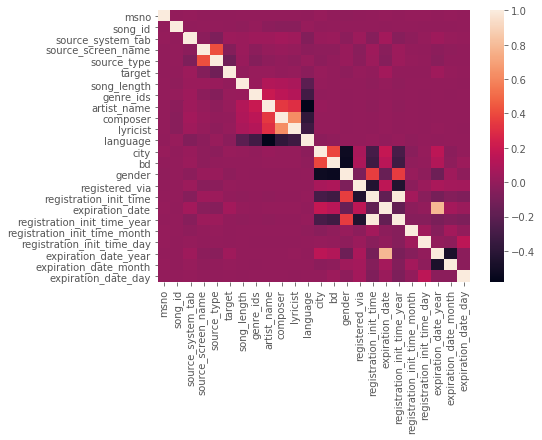

In [11]:
# Use correlation matrix to examine the correlation relationships between variables
plt.figure(figsize=[7,5])
sns.heatmap(df.corr())
plt.show()

In [12]:
# Drop highly correlative columns
df = df.drop(['expiration_date', 'lyricist'], 1)

In [13]:
# Split the dataset into training data and test data

# Train & Test split
target = df.pop('target')
train_data, test_data, train_labels, test_labels = train_test_split(df, target, test_size = 0.3)


In [14]:
# Creat Ramdom Forest Model
modelRF = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
modelRF.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
# Predicting Random Forest
predict_labels_RF = modelRF.predict(test_data)
# Print the confusion matrix
print(metrics.classification_report(test_labels, predict_labels_RF))

              precision    recall  f1-score   support

           0       0.68      0.63      0.66    110054
           1       0.66      0.71      0.68    111269

    accuracy                           0.67    221323
   macro avg       0.67      0.67      0.67    221323
weighted avg       0.67      0.67      0.67    221323



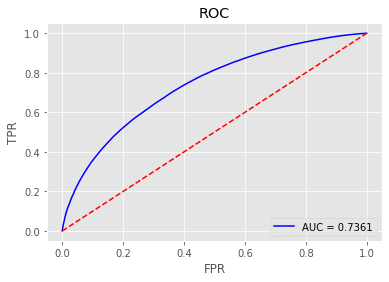

In [17]:
# Define ROC Curve function
def plot_roc(labels, predict_prob):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')

# Print the ROC Curve of the random forest model
predict_proba_RF = modelRF.predict_proba(test_data)[:,1]
plot_roc(test_labels,predict_proba_RF)

In [18]:
# Create XGB model
modelXGB = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=250)
modelXGB.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
# Predicting XGB
predict_labels_XGB = modelXGB.predict(test_data)

In [20]:
# Print the confusion matrix
print(metrics.classification_report(test_labels, predict_labels_XGB))

              precision    recall  f1-score   support

           0       0.69      0.66      0.67    110054
           1       0.67      0.70      0.69    111269

    accuracy                           0.68    221323
   macro avg       0.68      0.68      0.68    221323
weighted avg       0.68      0.68      0.68    221323



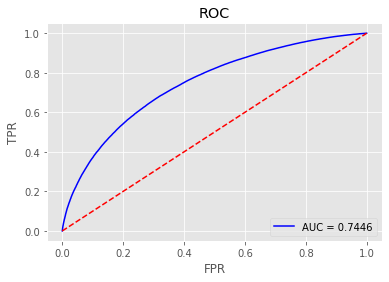

In [21]:
# Print the ROC Curve of the XGB model
predict_proba_XGB = modelXGB.predict_proba(test_data)[:,1]
plot_roc(test_labels,predict_proba_XGB)

In [22]:
# Construct training and validation dataset for LGB Model
lgb_train = lgb.Dataset(train_data, train_labels)
lgb_test = lgb.Dataset(test_data, test_labels)

In [23]:
# Set the parameters
params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'learning_rate': 0.2 ,
        'verbose': 0,
        'num_leaves': 100,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'num_rounds': 200,
        'metric' : 'auc'
    }
# LGBM Model
modelLGBM = lgb.train(params, train_set = lgb_train, valid_sets = lgb_test, verbose_eval=5)
# Verbose_eval prints output after every 5 iterations

[5]	valid_0's auc: 0.677652
[10]	valid_0's auc: 0.68468
[15]	valid_0's auc: 0.688868
[20]	valid_0's auc: 0.69456
[25]	valid_0's auc: 0.698077
[30]	valid_0's auc: 0.700623
[35]	valid_0's auc: 0.703449
[40]	valid_0's auc: 0.705278
[45]	valid_0's auc: 0.707203
[50]	valid_0's auc: 0.708191
[55]	valid_0's auc: 0.709872
[60]	valid_0's auc: 0.71071
[65]	valid_0's auc: 0.711606
[70]	valid_0's auc: 0.712522
[75]	valid_0's auc: 0.713755
[80]	valid_0's auc: 0.714835
[85]	valid_0's auc: 0.716052
[90]	valid_0's auc: 0.716863
[95]	valid_0's auc: 0.717753
[100]	valid_0's auc: 0.718455
[105]	valid_0's auc: 0.718854
[110]	valid_0's auc: 0.719327
[115]	valid_0's auc: 0.719783
[120]	valid_0's auc: 0.720488
[125]	valid_0's auc: 0.720711
[130]	valid_0's auc: 0.721042
[135]	valid_0's auc: 0.721456
[140]	valid_0's auc: 0.722087
[145]	valid_0's auc: 0.722217
[150]	valid_0's auc: 0.722625
[155]	valid_0's auc: 0.723045
[160]	valid_0's auc: 0.723488
[165]	valid_0's auc: 0.723695
[170]	valid_0's auc: 0.724205
[17